Required pips

In [ ]:
!pip -q install emoji==2.12.1 regex==2024.5.15 wordcloud==1.9.3 networkx==3.2.1 scikit-learn==1.5.1 textblob==0.18.0 nltk==3.9.1 python-dateutil==2.9.0.post0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.8/788.8 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 39.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.


Required imports

In [ ]:
import os
import re
import regex as reg
import math
import json
import textwrap
from collections import Counter, defaultdict
from datetime import datetime, timedelta
from dateutil import parser as dateparser


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from wordcloud import WordCloud
import networkx as nx


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer


import emoji
from textblob import TextBlob


try:
  from google.colab import files
  IN_COLAB = True
except Exception:
  IN_COLAB = False


nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Additional config for threshold params

In [ ]:
class CFG:
  tz_name = 'Europe/London' # for display purposes; WhatsApp timestamps are assumed local
  conversation_gap_minutes = 120 # gap that defines a new conversation
  top_n_emojis = 25
  in_msgs_for_user = 20 # threshold for showing users during plotting
  min_msgs_for_model_user = 20 # threshold to include user class in sender prediction model
  random_state = 42
  # WordCloud
  wc_width = 1400
  wc_height = 600


  # Clustering
  n_clusters = 3 # for KMeans when group chat has many users


  # Output dir
  outdir = 'outputs'


os.makedirs(CFG.outdir, exist_ok=True)

Detect emojis and compute counts

In [ ]:
EMOJI_PATTERN = reg.compile(r"\p{Emoji}")


def extract_emojis(text: str):
  return EMOJI_PATTERN.findall(text)

Upload WhatsApp files(.txt)

In [ ]:
if IN_COLAB:
  print("Please upload your exported WhatsApp chat .txt file…")
  uploaded = files.upload()
  assert len(uploaded) == 1, "Upload exactly one .txt file."
  fname = list(uploaded.keys())[0]
else:
  # For local testing, set a path manually
  fname = 'chat.txt' # replace with your path


print("Using file:", fname)

Please upload your exported WhatsApp chat .txt file…


Saving WhatsApp Chat with Marc Gonsalves.txt to WhatsApp Chat with Marc Gonsalves.txt
Using file: WhatsApp Chat with Marc Gonsalves.txt


Parsing the chats

In [ ]:
import re

# date: 1-2 digits /.- 1-2 digits /.- 2-4 digits
DATE = r'(\d{1,2}[\/\.\-]\d{1,2}[\/\.\-]\d{2,4})'

# time: HH:MM or HH:MM:SS
TIME_CORE = r'\d{1,2}:\d{2}(?::\d{2})?'

# am/pm variations: am, pm, AM, PM, a.m., p.m., optional normal or narrow no-break space
AMPM = r'(?:[\s\u00A0\u202F]?(?:[AaPp]\.?[Mm]\.?))?'

TIME_AMPM = rf'({TIME_CORE}{AMPM})'

# common spaces in exports
SP = r'(?:\s|\u00A0|\u202F)'

# dash can be hyphen -, en dash – (U+2013), or em dash — (U+2014)
DASH = r'[-\u2013\u2014]'

# [dd/mm/yyyy, hh:mm(:ss) am/pm] rest
BRACKETED = re.compile(rf'^\[{DATE},{SP}{TIME_AMPM}\]{SP}(.*)$')

# dd/mm/yyyy, hh:mm(:ss) am/pm - rest
HYPHENED  = re.compile(rf'^{DATE},{SP}{TIME_AMPM}{SP}{DASH}{SP}(.*)$')


Some system message catches

In [ ]:
SYSTEM_HINTS = (
'Messages to this group are now secured',
'Message and calls are end-to-end encrypted',
'changed the subject',
'changed this group\'s icon',
'added', 'removed', 'left', 'joined using this group\'s invite link', 'video call', 'missed voice call'
)

parsing the date lines from the remainder of the msg

In [ ]:
def try_parse_header(line: str):
    """Split a line into (datetime, remainder). Return (dt, remainder) or (None, None)."""

    # Normalize invisible spaces and exotic dashes so regex has an easier job
    if line is None:
        return None, None
    line = (line
            .replace('\u00A0', ' ')   # no-break space
            .replace('\u202F', ' ')   # narrow no-break space
            .replace('\u2013', '-')   # en dash
            .replace('\u2014', '-')   # em dash
            )

    m = BRACKETED.match(line)
    if not m:
        m = HYPHENED.match(line)
    if not m:
        return None, None

    dstr, tstr, rest = m.groups()
    dtstr = f"{dstr} {tstr}"

    # Try day-first first; if None, try month-first
    from dateutil import parser as dateparser
    dt = None
    try:
        dt = dateparser.parse(dtstr, dayfirst=True, fuzzy=True)
    except Exception:
        pass
    if dt is None:
        try:
            dt = dateparser.parse(dtstr, dayfirst=False, fuzzy=True)
        except Exception:
            return None, None

    return dt, rest


parsing if the message has a recipient or its a system msg

In [ ]:
def split_sender_message(rest: str):
    """Split 'Sender: message' if present, else treat as system message (sender=None)."""
    for sep in [': ', '：', ':', '： ']:
        if sep in rest:
            sender, msg = rest.split(sep, 1)
            return sender.strip(), msg.strip()
    return None, rest.strip()

parsing chats of the entire file if its an actual message or a system msg

In [ ]:
import pandas as pd

def parse_chat(filepath: str) -> pd.DataFrame:
    records = []
    prev = None

    # Try utf-8, fall back to utf-8-sig (BOM) then latin-1 if needed
    encodings = ['utf-8', 'utf-8-sig', 'latin-1']
    for enc in encodings:
        try:
            f = open(filepath, 'r', encoding=enc)
            break
        except Exception:
            f = None
    if f is None:
        raise ValueError("Could not open file with common encodings (utf-8/utf-8-sig/latin-1).")

    with f:
        for raw_line in f:
            line = raw_line.rstrip('\n')

            # header?
            dt, rest = try_parse_header(line)
            if dt is not None:
                sender, msg = split_sender_message(rest)
                rec = {'datetime': dt, 'sender': sender, 'message': msg}
                records.append(rec)
                prev = rec
            else:
                # continuation of previous message
                if prev is not None:
                    prev['message'] = (prev['message'] + '\n' + line).strip()
                else:
                    # orphan line before any header; ignore
                    pass

    df = pd.DataFrame.from_records(records)
    if df.empty:
        raise ValueError('Parsed DataFrame is empty. Check your chat export format.')
    # system flag pass 1
    df['is_system'] = df['sender'].isna()
    # heuristic phrases
    sys_mask = df['message'].fillna('').str.contains('|'.join([re.escape(x) for x in SYSTEM_HINTS]),
                                                     case=False, na=False)
    df.loc[sys_mask, 'is_system'] = True
    df.loc[df['is_system'], 'sender'] = 'SYSTEM'
    return df


Loading & cleaning </br>
1.Timestamps extraction


In [ ]:
df = parse_chat(fname)
print(f"Parsed rows: {len(df)}")
print(df.head(3))



Parsed rows: 318
             datetime                sender  \
0 2024-09-09 18:05:00                SYSTEM   
1 2024-09-09 18:05:00  seadon rodrigues(UK)   
2 2024-09-09 18:05:00  seadon rodrigues(UK)   

                                             message  is_system  
0  Messages and calls are end-to-end encrypted. O...       True  
1                                                Hey      False  
2                                      Please add me      False  


In [ ]:
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time

2.Time features

In [ ]:
# Hours and day-of-week etc.
df['hour'] = df['datetime'].dt.hour
# Monday=0 ... Sunday=6
WEEKDAY_NAMES = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
df['dow'] = df['datetime'].dt.dayofweek
df['dow_name'] = df['dow'].map(lambda i: WEEKDAY_NAMES[i])


df['month'] = df['datetime'].dt.month
MONTH_NAMES = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df['month_name'] = df['month'].map(lambda m: MONTH_NAMES[m-1])


df['year'] = df['datetime'].dt.year

3. Text features

In [ ]:
df['message'] = df['message'].fillna('')


df['char_count'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().apply(len)

4. Emoji features

In [ ]:
df['emojis'] = df['message'].apply(extract_emojis)
df['emoji_count'] = df['emojis'].apply(len)

5. System flag refined: if sender == SYSTEM or message empty

In [ ]:
df['is_system'] = (df['sender'] == 'SYSTEM') | (df['sender'].isna())

Saving cleaned data

In [ ]:
usable = df[~df['is_system']].copy()

In [ ]:
clean_path = os.path.join(CFG.outdir, 'clean_messages.csv')
df.to_csv(clean_path, index=False)
print(f"Saved cleaned full dataset → {clean_path}")


usable_path = os.path.join(CFG.outdir, 'usable_messages.csv')
usable.to_csv(usable_path, index=False)
print(f"Saved usable (non-system) dataset → {usable_path}")

Saved cleaned full dataset → outputs/clean_messages.csv
Saved usable (non-system) dataset → outputs/usable_messages.csv


EDA

In [ ]:
print("Rows:", len(df), "\nUsers (incl SYSTEM):", df['sender'].nunique())
print(df.groupby('sender')['message'].count().sort_values(ascending=False).head(10))

Rows: 318 
Users (incl SYSTEM): 3
sender
seadon rodrigues(UK)    180
Marc Gonsalves          135
SYSTEM                    3
Name: message, dtype: int64


Plotting most active/least active time period in the chats

In [ ]:
plt.rcParams['figure.figsize'] = (11, 6)
sns.set(style='whitegrid')

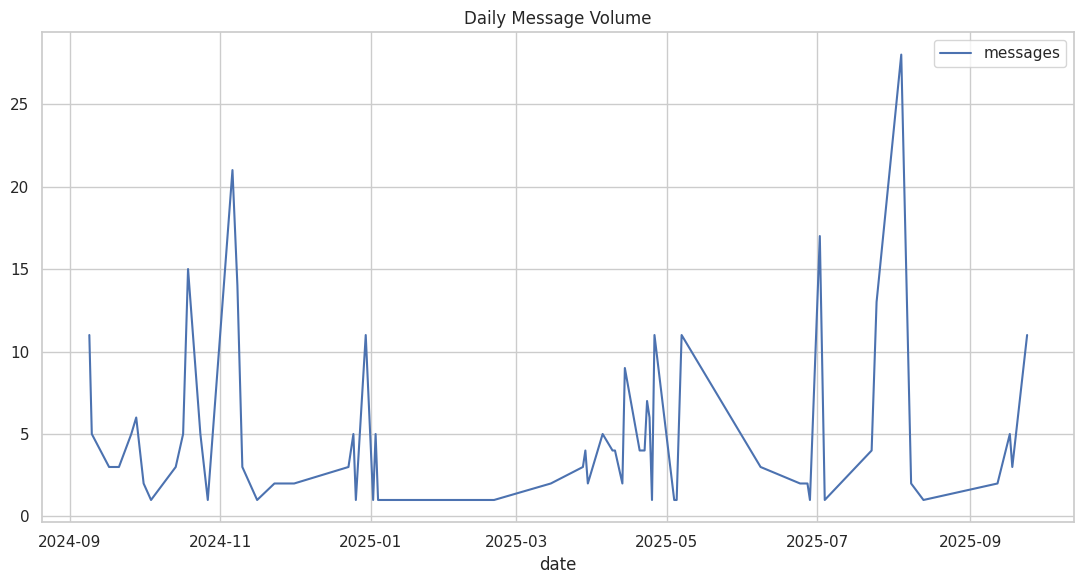

In [ ]:
daily = usable.groupby('date').size().rename('messages').reset_index()
ax = daily.plot(x='date', y='messages', kind='line', title='Daily Message Volume')
plt.tight_layout()
plt.savefig(os.path.join(CFG.outdir, 'daily_volume.png'), dpi=160)
plt.show()

Day vs Hour of the dau heatmap

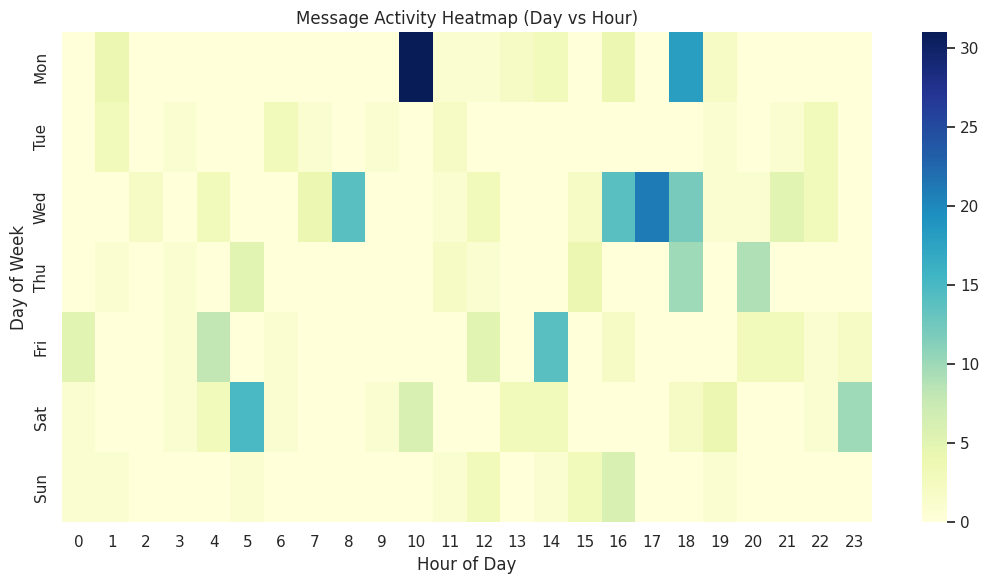

In [ ]:
pivot = usable.pivot_table(index='dow_name', columns='hour', values='message', aggfunc='count').reindex(WEEKDAY_NAMES)
sns.heatmap(pivot.fillna(0), cmap='YlGnBu')
plt.title('Message Activity Heatmap (Day vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.savefig(os.path.join(CFG.outdir, 'heatmap_day_hour.png'), dpi=160)
plt.show()

Top users by messages & words

In [ ]:
user_stats = usable.groupby('sender').agg(
messages=('message', 'count'),
words=('word_count', 'sum'),
emojis=('emoji_count', 'sum'),
avg_len=('word_count', 'mean')
).sort_values('messages', ascending=False)
print(user_stats.head(10))

                      messages  words  emojis   avg_len
sender                                                 
seadon rodrigues(UK)       180    733     211  4.072222
Marc Gonsalves             135    350      47  2.592593


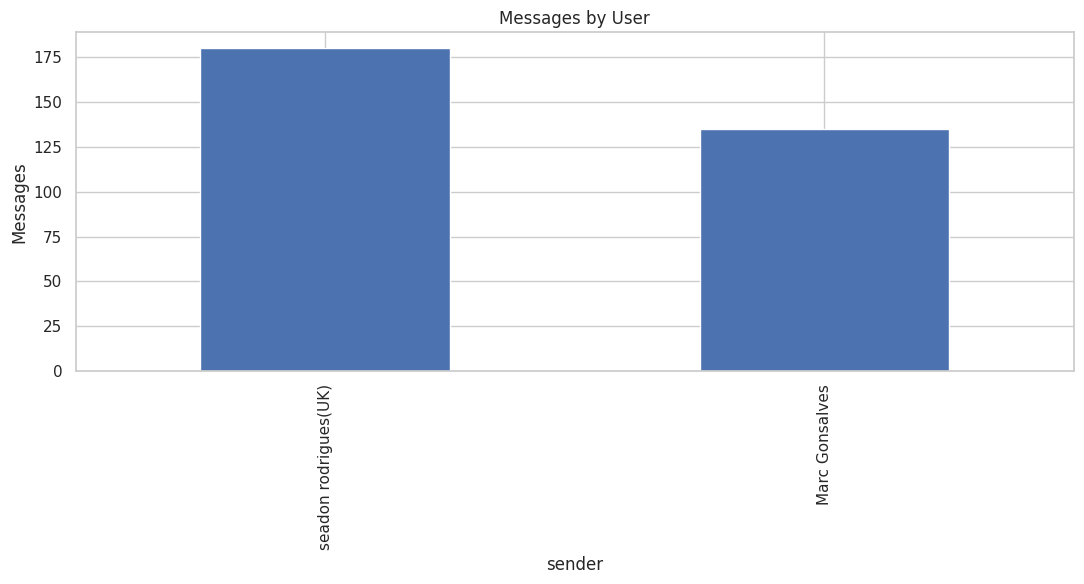

In [ ]:
ax = user_stats[user_stats['messages']>=CFG.in_msgs_for_user]['messages'].sort_values(ascending=False).plot(kind='bar', title='Messages by User')
plt.ylabel('Messages')
plt.tight_layout()
plt.savefig(os.path.join(CFG.outdir, 'messages_by_user.png'), dpi=160)
plt.show()

Emoji usage analysis</br> 1. Top emojis used



In [ ]:
import emoji

def extract_emojis(text: str):
    # emoji.emoji_list returns a list of dicts: {'emoji': '😂', 'match_start':..., 'match_end':...}
    return [d['emoji'] for d in emoji.emoji_list(text or "")]


usable['emojis'] = usable['message'].apply(extract_emojis)
usable['emoji_count'] = usable['emojis'].apply(len)



Top emojis:
 😂     16
🔥      9
❤️     4
😭      4
🤣      3
🚀      2
😍      2
🥲      1
💀      1
🎊      1
dtype: int64


/tmp/ipython-input-4056966966.py:9: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4056966966.py:9: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4056966966.py:9: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4056966966.py:9: UserWarning: Glyph 129394 (\N{SMILING FACE WITH TEAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4056966966.py:9: UserWarning: Glyph 128128 (\N{SKULL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4056966966.py:9: UserWarning: Glyph 127882 (\N{CONFETTI BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4056966966.py:10: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(CFG.outdir, 'top_emojis.png'), dpi=160)
/t

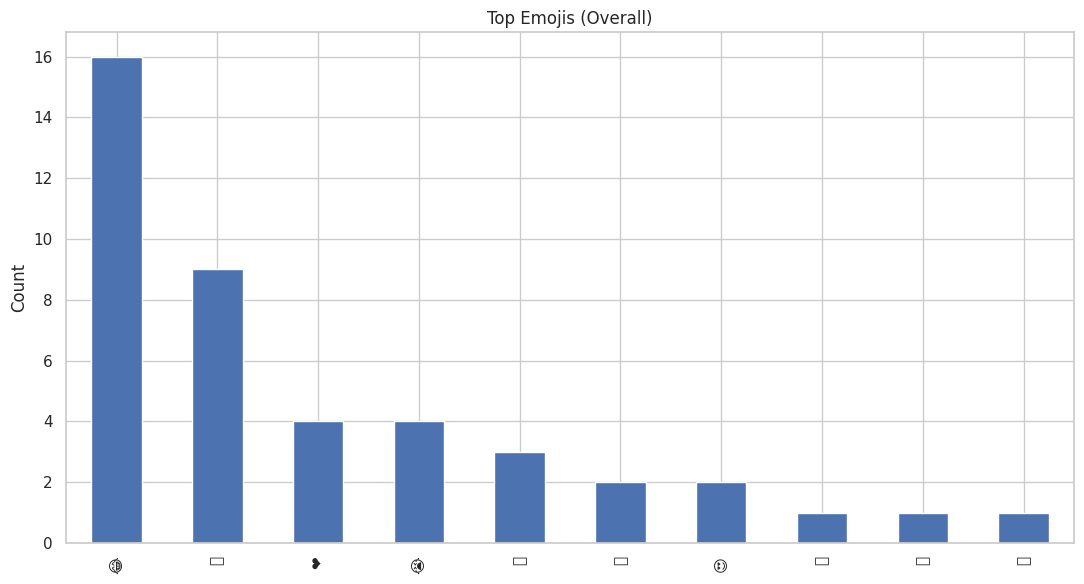

In [ ]:
from collections import Counter
all_emoji = [e for lst in usable['emojis'] for e in lst]
emoji_counts = pd.Series(Counter(all_emoji)).sort_values(ascending=False)

print("Top emojis:\n", emoji_counts.head(20))
emoji_counts.head(CFG.top_n_emojis).plot(kind='bar')
plt.title('Top Emojis (Overall)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(CFG.outdir, 'top_emojis.png'), dpi=160)
plt.show()

Sentiment analysis</br>
Converting text +emojis into text

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
def demojize_for_sentiment(text: str) -> str:
    t = emoji.demojize(text, language='en')
    # VADER handles words; turn :smiling_face: → smiling face
    t = t.replace(':', ' ').replace('_', ' ')
    return t

In [ ]:
usable['text_for_sent'] = usable['message'].apply(demojize_for_sentiment)

Calculating sentiment scores for each msg

In [ ]:
scores = usable['text_for_sent'].apply(sia.polarity_scores)
usable['sent_neg'] = scores.apply(lambda d: d['neg'])
usable['sent_neu'] = scores.apply(lambda d: d['neu'])
usable['sent_pos'] = scores.apply(lambda d: d['pos'])
usable['sent_compound'] = scores.apply(lambda d: d['compound'])

Calculating avg sentiment scores for both senders

In [ ]:
sent_by_user = usable.groupby('sender')['sent_compound'].mean().sort_values(ascending=False)
print("Avg compound sentiment by user:\n", sent_by_user)

Avg compound sentiment by user:
 sender
Marc Gonsalves          0.046645
seadon rodrigues(UK)    0.043982
Name: sent_compound, dtype: float64


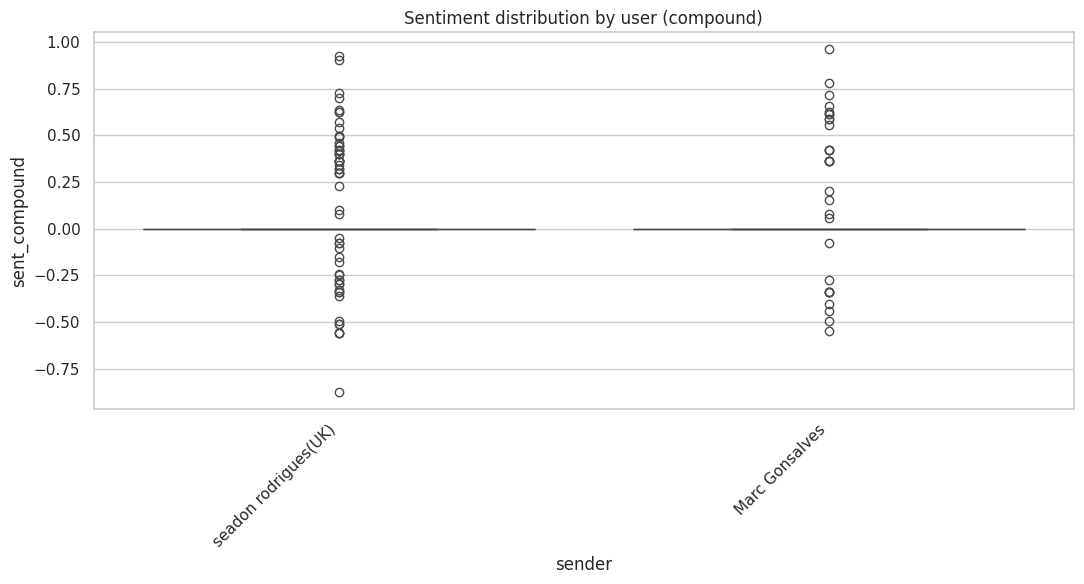

In [ ]:
sns.boxplot(data=usable[usable['sender'].map(usable['sender'].value_counts())>=CFG.in_msgs_for_user], x='sender', y='sent_compound')
plt.xticks(rotation=45, ha='right')
plt.title('Sentiment distribution by user (compound)')
plt.tight_layout()
plt.savefig(os.path.join(CFG.outdir, 'sentiment_by_user_box.png'), dpi=160)
plt.show()

Response time analysis

In [ ]:
usable = usable.sort_values('datetime').reset_index(drop=True)
usable['prev_sender'] = usable['sender'].shift(1)
usable['prev_time'] = usable['datetime'].shift(1)
usable['reply_gap_sec'] = (usable['datetime'] - usable['prev_time']).dt.total_seconds()

Only consider as a reply when sender changes

In [ ]:
mask_reply = usable['sender'] != usable['prev_sender']
replies = usable[mask_reply & usable['reply_gap_sec'].notna()].copy()

Overall reply gaps

In [ ]:
print("Overall median reply time (min):", np.nanmedian(replies['reply_gap_sec'])/60.0)

Overall median reply time (min): 1.0


Pairwise sender to sender reply times

In [ ]:
pair = replies.groupby(['prev_sender','sender'])['reply_gap_sec'].median().reset_index().rename(columns={'prev_sender':'from','sender':'to','reply_gap_sec':'median_reply_sec'})
print(pair.sort_values('median_reply_sec').head(10))

                   from                    to  median_reply_sec
0        Marc Gonsalves  seadon rodrigues(UK)              60.0
1  seadon rodrigues(UK)        Marc Gonsalves             360.0


Conversation starters

In [ ]:
usable['gap_min'] = usable['reply_gap_sec'] / 60.0
usable['new_conversation'] = usable['gap_min'] > CFG.conversation_gap_minutes
# First message is a new conversation by default
usable.loc[0, 'new_conversation'] = True


In [ ]:
starters = usable[usable['new_conversation']].groupby('sender').size().sort_values(ascending=False)
print("Conversation starters (count):\n", starters)

Conversation starters (count):
 sender
seadon rodrigues(UK)    53
Marc Gonsalves          28
dtype: int64


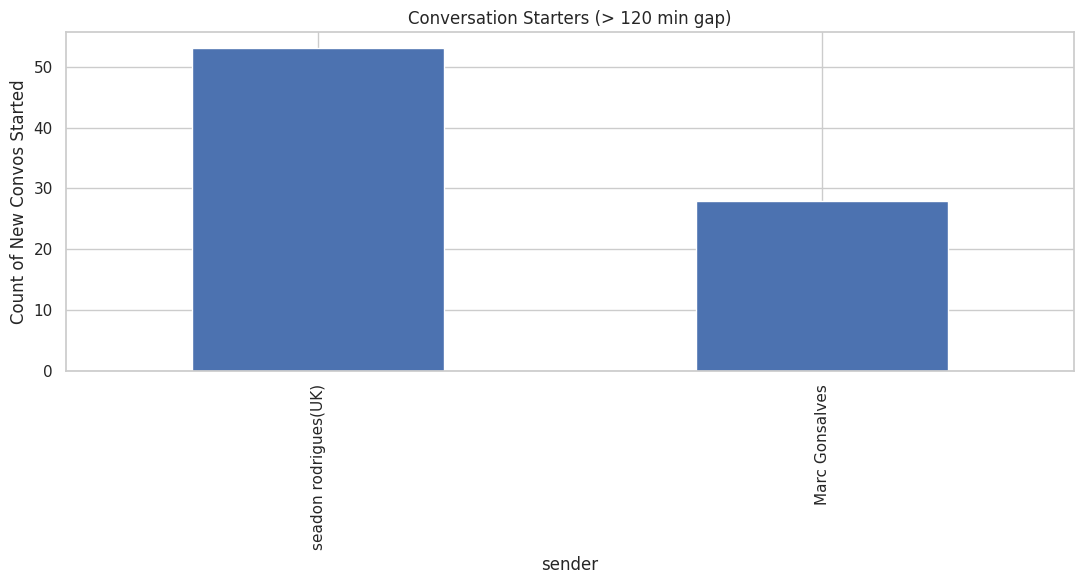

In [ ]:
ax = starters.plot(kind='bar', title=f'Conversation Starters (> {CFG.conversation_gap_minutes} min gap)')
plt.ylabel('Count of New Convos Started')
plt.tight_layout()
plt.savefig(os.path.join(CFG.outdir, 'conversation_starters.png'), dpi=160)
plt.show()

Generating wordcloud of both senders respectively(most used words in one's conversation)

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_for_wc(text: str) -> str:
    t = text.lower()
    t = re.sub(r'https?://\S+', ' ', t)
    t = re.sub(r'[^a-z\s]', ' ', t)
    tokens = [w for w in t.split() if w not in stop_words and len(w)>2]
    return ' '.join(tokens)

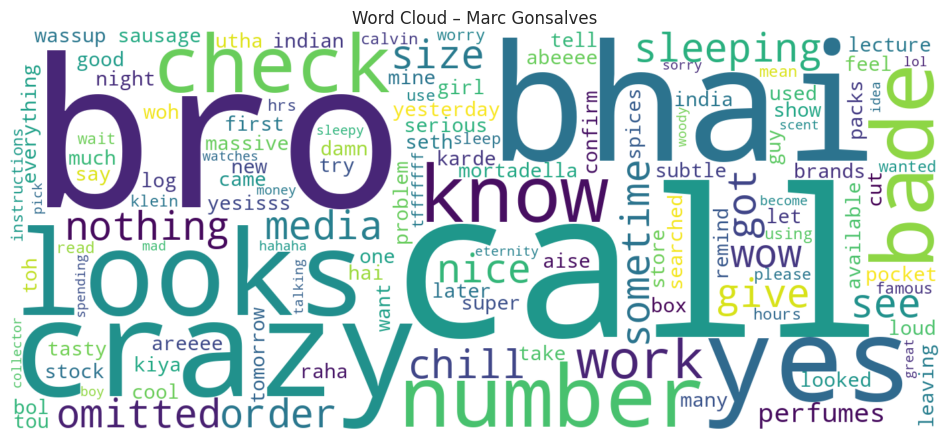

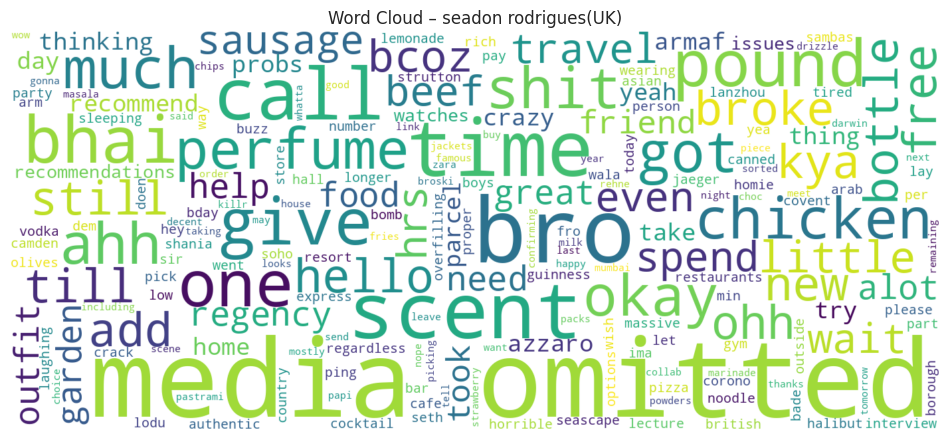

In [ ]:
for usr, sub in usable.groupby('sender'):
    if len(sub) < CFG.in_msgs_for_user:
        continue
    txt = ' '.join(sub['message'].astype(str).tolist())
    txt = clean_for_wc(txt)
    if not txt.strip():
        continue
    wc = WordCloud(width=CFG.wc_width, height=CFG.wc_height, background_color='white').generate(txt)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud – {usr}')
    fn = f"wordcloud_{re.sub('[^A-Za-z0-9]+','_',usr)}.png"
    plt.savefig(os.path.join(CFG.outdir, fn), dpi=160, bbox_inches='tight')
    plt.show()

Logistic regression model: based on some features who's more likely to send the msg

1. Filter users with enough msges

In [ ]:
user_counts = usable['sender'].value_counts()
eligible_users = user_counts[user_counts >= CFG.min_msgs_for_model_user].index.tolist()


2. Proceeding only if there are 2 or more users

In [ ]:
# create model_df to include your 2 users
model_df = usable[usable['sender'].isin(eligible_users)].copy()

print("Users included in the model:", model_df['sender'].unique())
print("Messages per user:\n", model_df['sender'].value_counts())



Users included in the model: ['seadon rodrigues(UK)' 'Marc Gonsalves']
Messages per user:
 sender
seadon rodrigues(UK)    180
Marc Gonsalves          135
Name: count, dtype: int64


3. Feature engineering (creating two features...is_night->msging between 10pm and 5am & is_weekend->if msg is sent during weekend)

In [ ]:
model_df['is_night'] = model_df['hour'].between(22, 23) | model_df['hour'].between(0, 5)
model_df['is_weekend'] = model_df['dow'].isin([5,6])


4. Defining input features

In [ ]:
X = model_df[['hour','word_count','emoji_count']].copy()
X['is_night']   = model_df['is_night'].astype(int)
X['is_weekend'] = model_df['is_weekend'].astype(int)

y = model_df['sender']


5. Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,
    random_state=CFG.random_state,
    stratify=y
)


6. Model prediction

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

print("Accuracy:", clf.score(X_test, y_test))


Accuracy: 0.5316455696202531
